# Vanilla GAN Illustrated: Learning 2D Distributions

This notebook demonstrates the power of **Generative Adversarial Networks (GANs)** on simple 2D toy datasets. By visualizing the learning process in 2D space, we can build intuition for how GANs work before applying them to more complex problems.

## Table of Contents
1. [Introduction & Theory](#theory)
2. [Data Generation](#data)
3. [Model Architecture](#model)
4. [Training Process](#training)
5. [Progressive Visualization](#progression)
6. [Results & Analysis](#results)
7. [Interactive Experiments](#experiments)
8. [Key Takeaways](#takeaways)

---
## 1. Introduction & Theory

### What is a GAN?

A **Generative Adversarial Network** consists of two neural networks playing a game:

- **Generator (G)**: Takes random noise $z \sim p_z(z)$ and produces fake samples $G(z)$
- **Discriminator (D)**: Tries to distinguish real data from fake data

### The Min-Max Game

The objective function is:

$$
\min_G \max_D \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

**In practice**, we use the **non-saturating** loss for the generator:

- **Discriminator loss**: Maximize $\log D(x) + \log(1 - D(G(z)))$
- **Generator loss**: Maximize $\log D(G(z))$ (equivalent to minimizing $-\log D(G(z))$)

### Why Toy Data?

Using 2D datasets like **Swiss Roll** and **Spirals** allows us to:
- Visualize the entire learning process
- Understand mode collapse and training dynamics
- Debug issues before scaling to high-dimensional data
- Build intuition for what the generator is learning

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.datasets import make_swiss_roll
from scipy import stats

from typing import Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 2. Data Generation

We'll create two classic 2D datasets:
1. **Swiss Roll**: A 3D manifold projected to 2D
2. **Spiral**: Two intertwined spirals

In [2]:
def generate_swiss_roll(n_samples: int = 10000, noise: float = 0.15, seed: int = 42) -> np.ndarray:
    """
    Generate 2D Swiss Roll data.
    
    Args:
        n_samples: Number of samples to generate
        noise: Amount of noise to add
        seed: Random seed for reproducibility
    
    Returns:
        Array of shape (n_samples, 2)
    """
    X, _ = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)
    X = X[:, [0, 2]]  # Select two dimensions for 2D visualization
    
    # Normalize to zero mean and unit variance
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


def generate_spiral(n_samples: int = 10000, noise: float = 0.1, seed: int = 42) -> np.ndarray:
    """
    Generate 2D two-spiral data.
    
    Args:
        n_samples: Number of samples to generate (will be split between two spirals)
        noise: Amount of Gaussian noise to add
        seed: Random seed for reproducibility
    
    Returns:
        Array of shape (n_samples, 2)
    """
    np.random.seed(seed)
    n = n_samples // 2
    
    # Generate theta values
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi  # Spiral parameter
    
    # First spiral
    r = 2 * theta + np.pi
    x1 = r * np.cos(theta) + noise * np.random.randn(n)
    y1 = r * np.sin(theta) + noise * np.random.randn(n)
    
    # Second spiral (rotated by pi)
    x2 = -r * np.cos(theta) + noise * np.random.randn(n)
    y2 = -r * np.sin(theta) + noise * np.random.randn(n)
    
    # Combine both spirals
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    
    # Normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


# Generate datasets
swiss_roll_data = generate_swiss_roll(n_samples=10000)
spiral_data = generate_spiral(n_samples=10000)

print(f"Swiss Roll shape: {swiss_roll_data.shape}")
print(f"Spiral shape: {spiral_data.shape}")
print(f"\nSwiss Roll stats - Mean: {swiss_roll_data.mean(axis=0)}, Std: {swiss_roll_data.std(axis=0)}")
print(f"Spiral stats - Mean: {spiral_data.mean(axis=0)}, Std: {spiral_data.std(axis=0)}")

Swiss Roll shape: (10000, 2)
Spiral shape: (10000, 2)

Swiss Roll stats - Mean: [9.23705556e-18 2.66453526e-18], Std: [1. 1.]
Spiral stats - Mean: [-2.19019247e-16  1.90802929e-16], Std: [1. 1.]


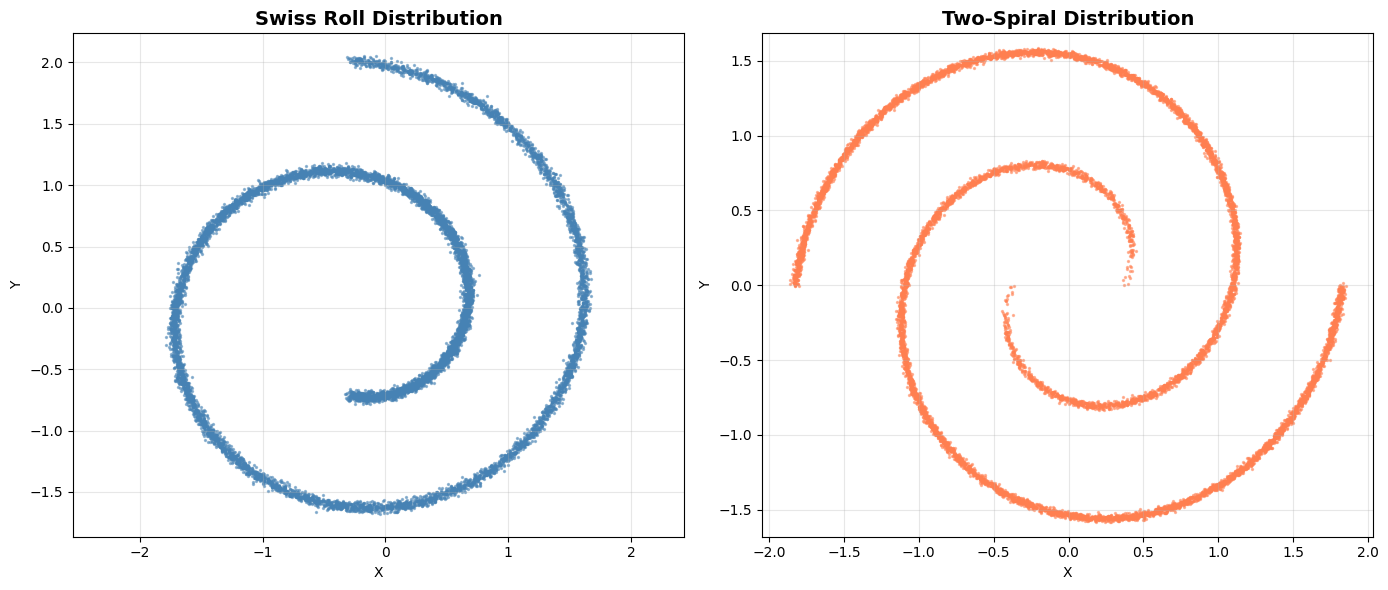

In [3]:
# Visualize both datasets
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Swiss Roll
axes[0].scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], 
                s=2, alpha=0.5, c='steelblue')
axes[0].set_title('Swiss Roll Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Spiral
axes[1].scatter(spiral_data[:, 0], spiral_data[:, 1], 
                s=2, alpha=0.5, c='coral')
axes[1].set_title('Two-Spiral Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

---
## 3. Model Architecture

We'll implement simple but flexible MLP architectures for both Generator and Discriminator.

### Design Choices:
- **Generator**: Maps from latent space (2D) to data space (2D)
- **Discriminator**: Maps from data space (2D) to a single logit
- **Activation**: LeakyReLU(0.2) for stability
- **Dropout**: Optional, typically helps more in the Discriminator
- **Initialization**: DCGAN-style normal initialization

In [4]:
class FlexibleMLP(nn.Module):
    """
    A configurable MLP: [in -> (Linear, Act, Dropout)* -> out]
    
    Args:
        in_dim: Input dimension
        out_dim: Output dimension
        hidden_sizes: List of hidden layer sizes (e.g., [128, 128])
        activation: Activation function to use
        dropout: Dropout probability (0.0 disables)
        final_activation: Optional activation after final layer
    """
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        hidden_sizes: List[int],
        activation: nn.Module = nn.LeakyReLU(0.2, inplace=True),
        dropout: float = 0.0,
        final_activation: Optional[nn.Module] = None,
    ):
        super().__init__()
        layers: List[nn.Module] = []
        prev = in_dim
        
        # Build hidden layers
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(activation)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        
        # Output layer
        layers.append(nn.Linear(prev, out_dim))
        if final_activation is not None:
            layers.append(final_activation)
        
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Generator(nn.Module):
    """
    Generator network: latent_dim -> data_dim
    
    Args:
        latent_dim: Dimension of latent space (noise input)
        data_dim: Dimension of output data
        hidden_sizes: List of hidden layer sizes
        activation: Activation function
        dropout: Dropout probability
    """
    def __init__(
        self,
        latent_dim: int,
        data_dim: int,
        hidden_sizes: List[int],
        activation: nn.Module = nn.LeakyReLU(0.2, inplace=True),
        dropout: float = 0.0,
    ):
        super().__init__()
        self.net = FlexibleMLP(
            in_dim=latent_dim,
            out_dim=data_dim,
            hidden_sizes=hidden_sizes,
            activation=activation,
            dropout=dropout,
            final_activation=None,  # Linear output
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class Discriminator(nn.Module):
    """
    Discriminator network: data_dim -> 1 (logit)
    
    Args:
        data_dim: Dimension of input data
        hidden_sizes: List of hidden layer sizes
        activation: Activation function
        dropout: Dropout probability
    """
    def __init__(
        self,
        data_dim: int,
        hidden_sizes: List[int],
        activation: nn.Module = nn.LeakyReLU(0.2, inplace=True),
        dropout: float = 0.0,
    ):
        super().__init__()
        self.net = FlexibleMLP(
            in_dim=data_dim,
            out_dim=1,
            hidden_sizes=hidden_sizes,
            activation=activation,
            dropout=dropout,
            final_activation=None,  # Logits for BCEWithLogitsLoss
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).view(-1)


def init_weights(m: nn.Module):
    """DCGAN-style weight initialization."""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


# Test the models
latent_dim = 2
data_dim = 2
hidden_sizes = [128, 128, 128]

G = Generator(latent_dim, data_dim, hidden_sizes, dropout=0.0).to(device)
D = Discriminator(data_dim, hidden_sizes, dropout=0.1).to(device)

# Initialize weights
G.apply(init_weights)
D.apply(init_weights)

print("Generator Architecture:")
print(G)
print(f"\nGenerator parameters: {sum(p.numel() for p in G.parameters()):,}")
print(f"\nDiscriminator Architecture:")
print(D)
print(f"\nDiscriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

# Test forward pass
z = torch.randn(5, latent_dim).to(device)
fake_samples = G(z)
logits = D(fake_samples)
print(f"\nTest: z.shape={z.shape} -> G(z).shape={fake_samples.shape} -> D(G(z)).shape={logits.shape}")

Generator Architecture:
Generator(
  (net): FlexibleMLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)

Generator parameters: 33,666

Discriminator Architecture:
Discriminator(
  (net): FlexibleMLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, b

---
## 4. Training Process

We'll implement the vanilla GAN training loop with:
- **Non-saturating generator loss**
- **Binary cross-entropy for discriminator**
- **Label smoothing** (real labels = 0.9 instead of 1.0)
- **Progress tracking** for losses and discriminator outputs

In [5]:
def train_gan(
    data: np.ndarray,
    latent_dim: int = 2,
    hidden_sizes: List[int] = [128, 128, 128],
    batch_size: int = 128,
    n_steps: int = 20000,
    lr: float = 1e-4,
    beta1: float = 0.5,
    beta2: float = 0.999,
    n_disc: int = 1,
    real_label_smoothing: float = 0.9,
    instance_noise: float = 0.0,
    print_every: int = 1000,
    save_samples_every: int = 2000,
    device: torch.device = device,
) -> Tuple[Generator, Discriminator, dict]:
    """
    Train a vanilla GAN on 2D data.
    
    Args:
        data: Training data of shape (n_samples, 2)
        latent_dim: Dimension of latent space
        hidden_sizes: Hidden layer sizes for both G and D
        batch_size: Batch size for training
        n_steps: Number of training steps
        lr: Learning rate
        beta1, beta2: Adam optimizer betas
        n_disc: Number of discriminator updates per generator update
        real_label_smoothing: Value for real labels (1.0 = no smoothing)
        instance_noise: Std of noise to add to inputs (0.0 = no noise)
        print_every: Print statistics every N steps
        save_samples_every: Save generated samples every N steps
        device: Device to train on
    
    Returns:
        Trained generator, discriminator, and training history
    """
    data_dim = data.shape[1]
    
    # Create data loader
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    G = Generator(latent_dim, data_dim, hidden_sizes, dropout=0.0).to(device)
    D = Discriminator(data_dim, hidden_sizes, dropout=0.1).to(device)
    G.apply(init_weights)
    D.apply(init_weights)
    
    # Optimizers
    g_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    d_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    
    # Loss function
    bce = nn.BCEWithLogitsLoss()
    
    # Helper function to sample latent vectors
    def sample_z(n):
        return torch.randn(n, latent_dim, device=device)
    
    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'd_real': [],
        'd_fake': [],
        'samples': [],
        'steps': []
    }
    
    # Training loop
    it = iter(loader)
    for step in range(1, n_steps + 1):
        # ===== Discriminator training =====
        d_loss_acc = 0.0
        d_real_acc = 0.0
        d_fake_acc = 0.0
        
        for _ in range(n_disc):
            # Get real data
            try:
                real = next(it)[0].to(device)
            except StopIteration:
                it = iter(loader)
                real = next(it)[0].to(device)
            
            # Add instance noise if specified
            if instance_noise > 0:
                real = real + instance_noise * torch.randn_like(real)
            
            # Generate fake data
            z = sample_z(len(real))
            fake = G(z).detach()
            if instance_noise > 0:
                fake = fake + instance_noise * torch.randn_like(fake)
            
            # Discriminator predictions
            d_real_logits = D(real)
            d_fake_logits = D(fake)
            
            # Losses (with label smoothing for real samples)
            y_real = torch.full_like(d_real_logits, real_label_smoothing)
            y_fake = torch.zeros_like(d_fake_logits)
            
            loss_real = bce(d_real_logits, y_real)
            loss_fake = bce(d_fake_logits, y_fake)
            d_loss = loss_real + loss_fake
            
            # Update discriminator
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
            
            # Accumulate for logging
            d_loss_acc += d_loss.item()
            d_real_acc += torch.sigmoid(d_real_logits).mean().item()
            d_fake_acc += torch.sigmoid(d_fake_logits).mean().item()
        
        avg_d_loss = d_loss_acc / n_disc
        avg_d_real = d_real_acc / n_disc
        avg_d_fake = d_fake_acc / n_disc
        
        # ===== Generator training =====
        z = sample_z(batch_size)
        fake = G(z)
        g_logits = D(fake)
        
        # Non-saturating loss: maximize log(D(G(z)))
        y_gen = torch.ones_like(g_logits)
        g_loss = bce(g_logits, y_gen)
        
        # Update generator
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        # ===== Logging =====
        history['g_loss'].append(g_loss.item())
        history['d_loss'].append(avg_d_loss)
        history['d_real'].append(avg_d_real)
        history['d_fake'].append(avg_d_fake)
        history['steps'].append(step)
        
        if step % print_every == 0 or step == 1:
            print(f"[{step:5d}/{n_steps}] D_loss={avg_d_loss:.4f} | G_loss={g_loss.item():.4f} | "
                  f"D(real)={avg_d_real:.3f} | D(fake)={avg_d_fake:.3f}")
        
        # Save samples for visualization
        if step % save_samples_every == 0 or step == 1:
            with torch.no_grad():
                samples = G(sample_z(5000)).cpu().numpy()
                history['samples'].append(samples)
    
    return G, D, history

### Train on Swiss Roll

In [6]:
print("Training GAN on Swiss Roll data...\n")
G_swiss, D_swiss, history_swiss = train_gan(
    data=swiss_roll_data,
    latent_dim=2,
    hidden_sizes=[128, 128, 128],
    batch_size=128,
    n_steps=20000,
    lr=1e-4,
    print_every=2000,
    save_samples_every=2000,
    device=device
)
print("\nTraining complete!")

Training GAN on Swiss Roll data...

[    1/20000] D_loss=1.3863 | G_loss=0.6932 | D(real)=0.500 | D(fake)=0.500
[ 2000/20000] D_loss=1.3688 | G_loss=0.9208 | D(real)=0.431 | D(fake)=0.405
[ 4000/20000] D_loss=1.3062 | G_loss=0.8660 | D(real)=0.475 | D(fake)=0.422
[ 6000/20000] D_loss=1.3724 | G_loss=0.8208 | D(real)=0.457 | D(fake)=0.451
[ 8000/20000] D_loss=1.3652 | G_loss=0.8030 | D(real)=0.458 | D(fake)=0.449
[10000/20000] D_loss=1.3252 | G_loss=0.8429 | D(real)=0.470 | D(fake)=0.437
[12000/20000] D_loss=1.3636 | G_loss=0.8114 | D(real)=0.454 | D(fake)=0.441
[14000/20000] D_loss=1.3957 | G_loss=0.8314 | D(real)=0.440 | D(fake)=0.445
[16000/20000] D_loss=1.3828 | G_loss=0.8087 | D(real)=0.447 | D(fake)=0.446
[18000/20000] D_loss=1.3620 | G_loss=0.8064 | D(real)=0.457 | D(fake)=0.445
[20000/20000] D_loss=1.3578 | G_loss=0.8137 | D(real)=0.459 | D(fake)=0.445

Training complete!


### Train on Spiral

In [7]:
print("Training GAN on Spiral data...\n")
G_spiral, D_spiral, history_spiral = train_gan(
    data=spiral_data,
    latent_dim=2,
    hidden_sizes=[128, 128, 128],
    batch_size=128,
    n_steps=20000,
    lr=1e-4,
    print_every=2000,
    save_samples_every=2000,
    device=device
)
print("\nTraining complete!")

Training GAN on Spiral data...

[    1/20000] D_loss=1.3863 | G_loss=0.6932 | D(real)=0.500 | D(fake)=0.500
[ 2000/20000] D_loss=1.0701 | G_loss=1.0330 | D(real)=0.590 | D(fake)=0.359
[ 4000/20000] D_loss=1.3997 | G_loss=0.8348 | D(real)=0.432 | D(fake)=0.432
[ 6000/20000] D_loss=1.3591 | G_loss=0.8323 | D(real)=0.455 | D(fake)=0.437
[ 8000/20000] D_loss=1.3571 | G_loss=0.8222 | D(real)=0.450 | D(fake)=0.436
[10000/20000] D_loss=1.3397 | G_loss=0.8232 | D(real)=0.463 | D(fake)=0.437
[12000/20000] D_loss=1.3808 | G_loss=0.8027 | D(real)=0.453 | D(fake)=0.453
[14000/20000] D_loss=1.3665 | G_loss=0.8031 | D(real)=0.457 | D(fake)=0.449
[16000/20000] D_loss=1.3742 | G_loss=0.8011 | D(real)=0.450 | D(fake)=0.446
[18000/20000] D_loss=1.3668 | G_loss=0.7882 | D(real)=0.462 | D(fake)=0.454
[20000/20000] D_loss=1.3667 | G_loss=0.8220 | D(real)=0.453 | D(fake)=0.444

Training complete!


---
## 5. Progressive Visualization

Let's visualize how the generator learns the distribution over time.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

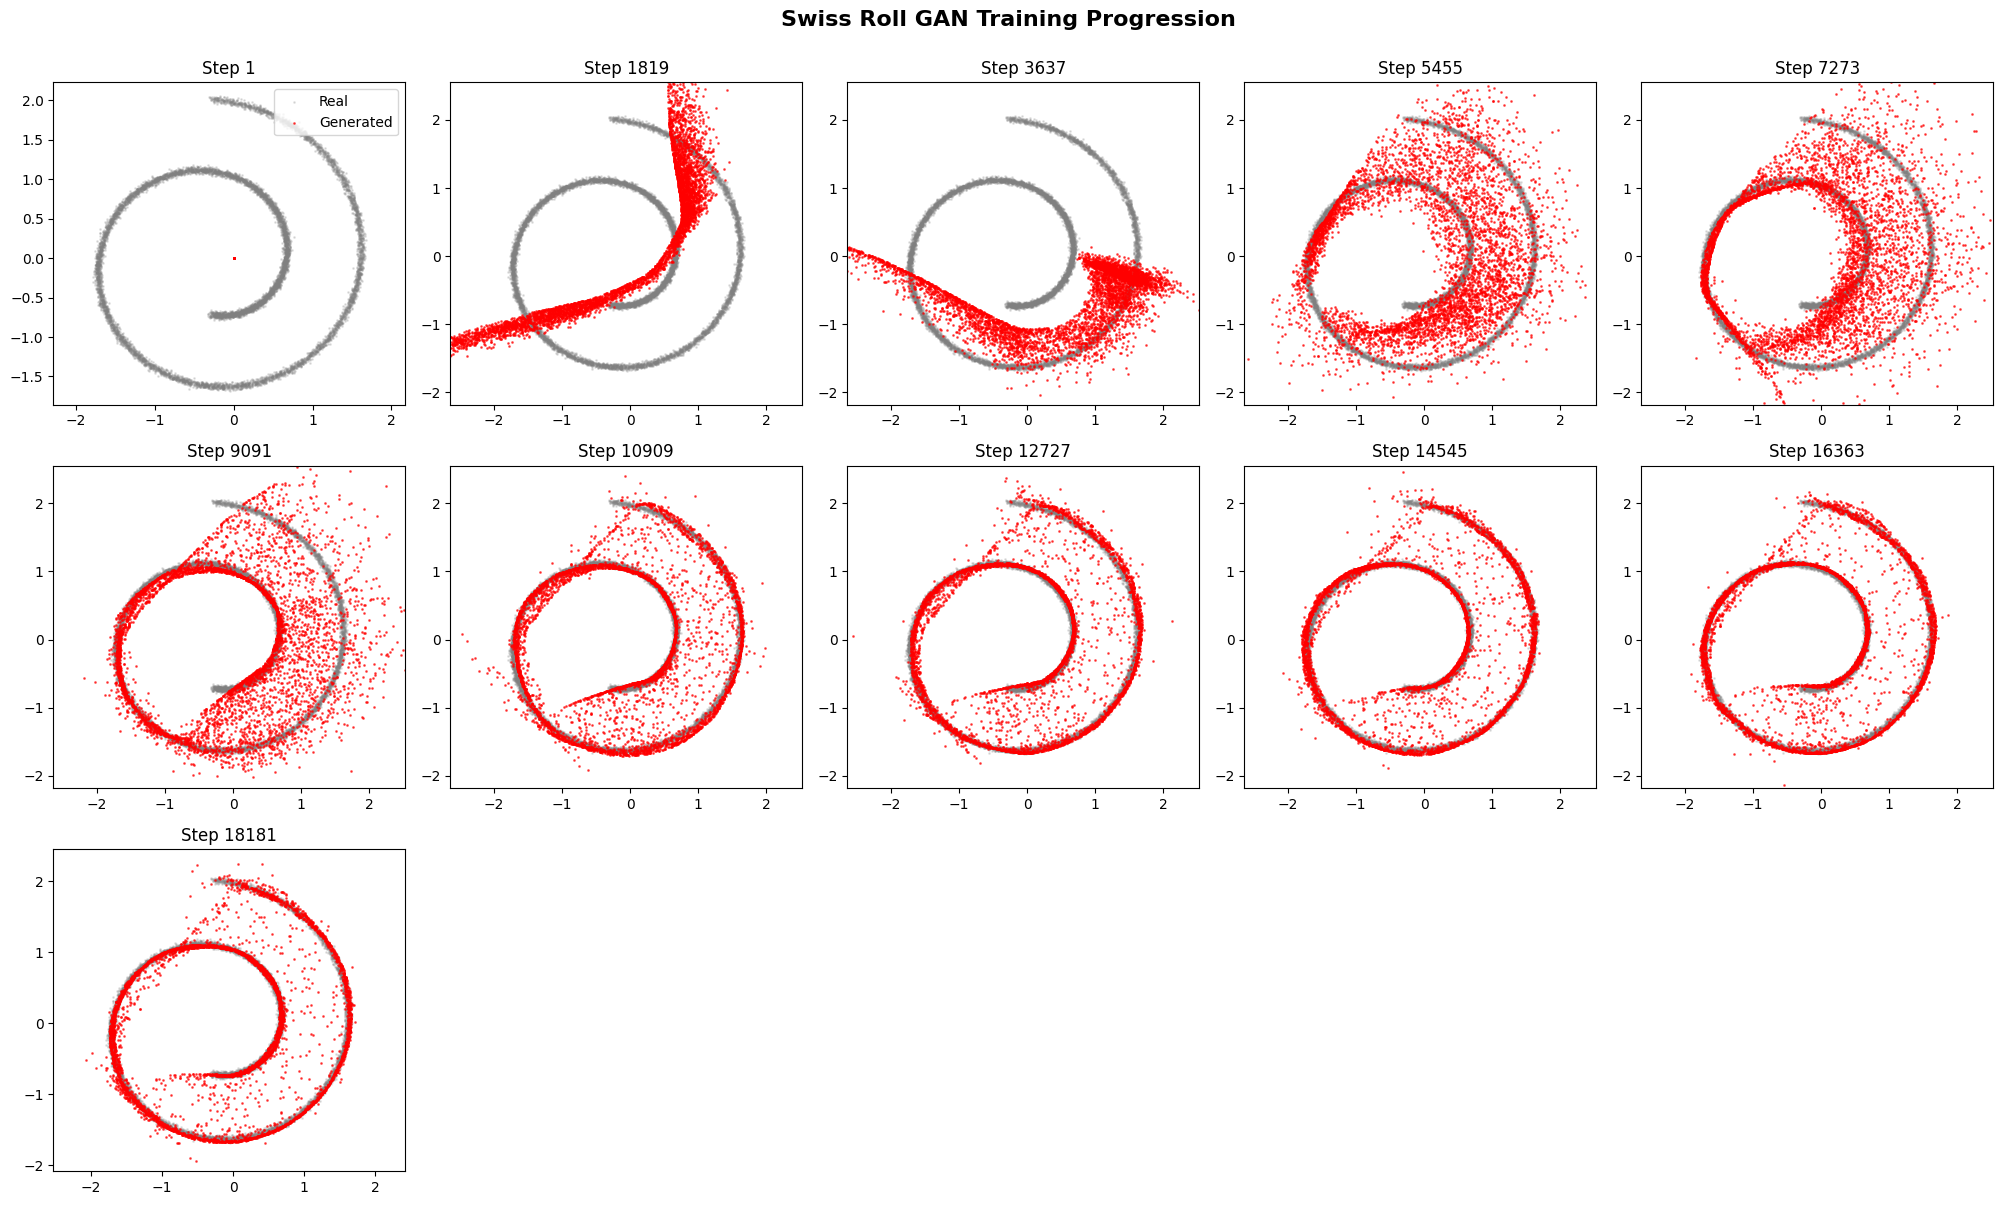

In [8]:
def plot_training_progression(real_data, history, title="GAN Training Progression"):
    """
    Plot the progression of generated samples during training.
    """
    samples_list = history['samples']
    n_snapshots = len(samples_list)
    
    # Create subplot grid
    n_cols = min(5, n_snapshots)
    n_rows = (n_snapshots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).flatten() if n_snapshots > 1 else [axes]
    
    for idx, (ax, samples) in enumerate(zip(axes[:n_snapshots], samples_list)):
        # Plot real data in background
        ax.scatter(real_data[:, 0], real_data[:, 1], 
                  s=1, alpha=0.2, c='gray', label='Real')
        # Plot generated samples
        ax.scatter(samples[:, 0], samples[:, 1], 
                  s=1, alpha=0.6, c='red', label='Generated')
        
        step = history['steps'][idx * (len(history['steps']) // n_snapshots)]
        ax.set_title(f'Step {step}', fontsize=12)
        ax.axis('equal')
        ax.set_xlim(real_data[:, 0].min() - 0.5, real_data[:, 0].max() + 0.5)
        ax.set_ylim(real_data[:, 1].min() - 0.5, real_data[:, 1].max() + 0.5)
        if idx == 0:
            ax.legend(loc='upper right')
    
    # Hide unused subplots
    for ax in axes[n_snapshots:]:
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()


# Plot progression for Swiss Roll
plot_training_progression(swiss_roll_data, history_swiss, "Swiss Roll GAN Training Progression")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

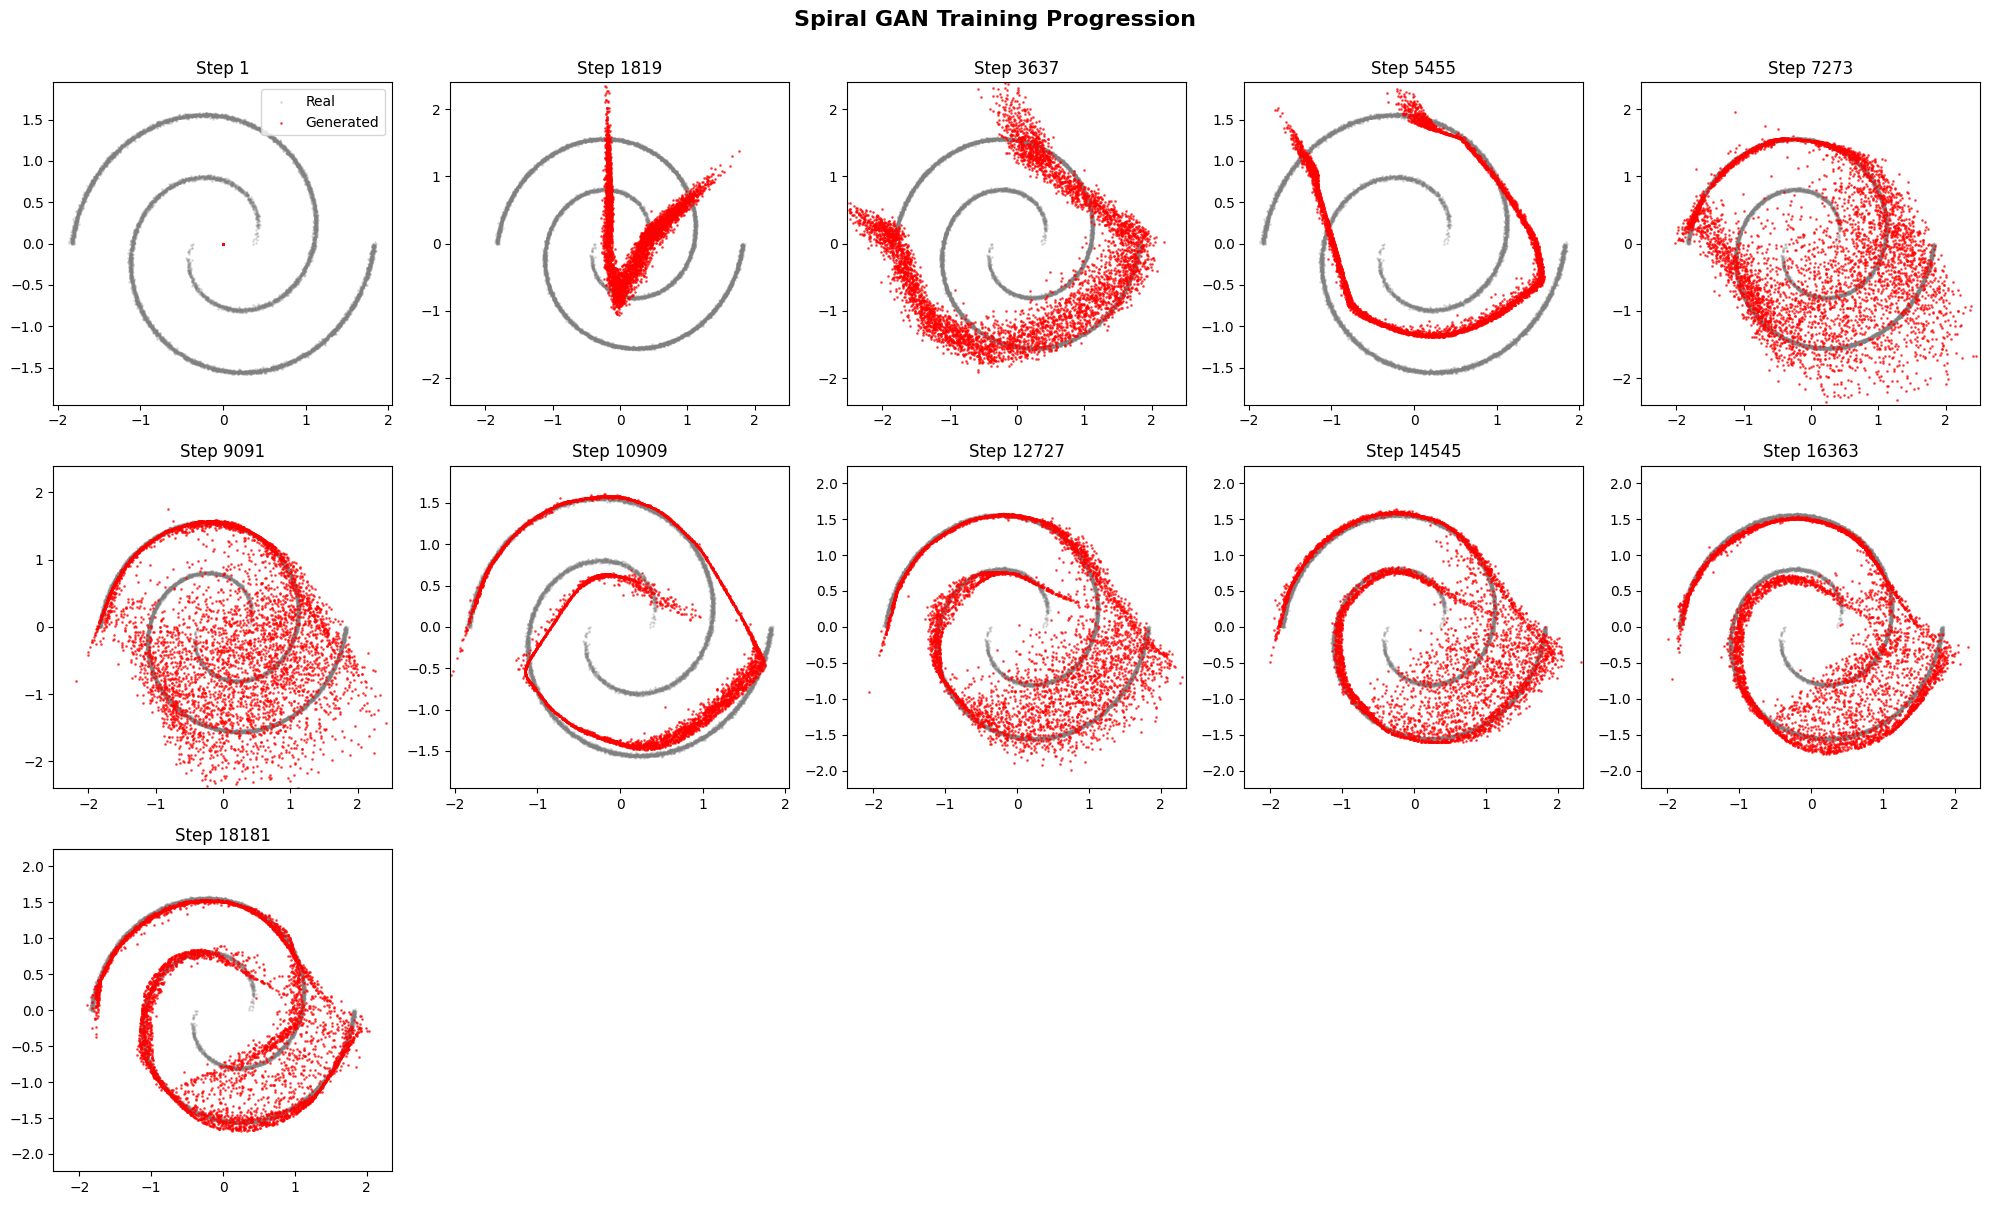

In [9]:
# Plot progression for Spiral
plot_training_progression(spiral_data, history_spiral, "Spiral GAN Training Progression")

### Loss Curves

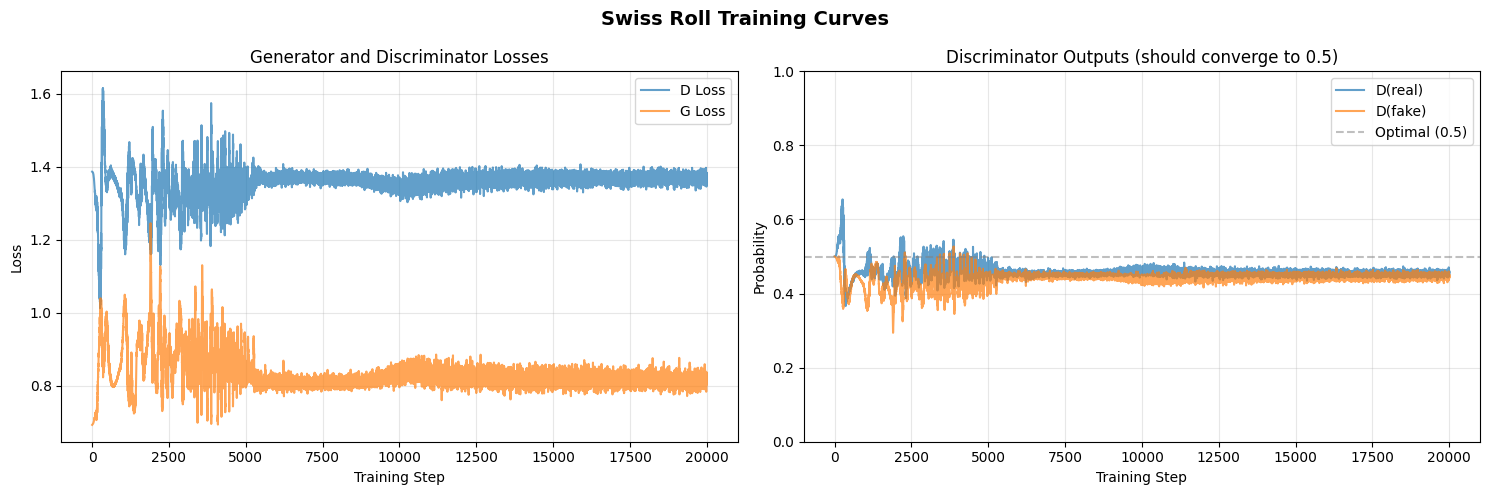

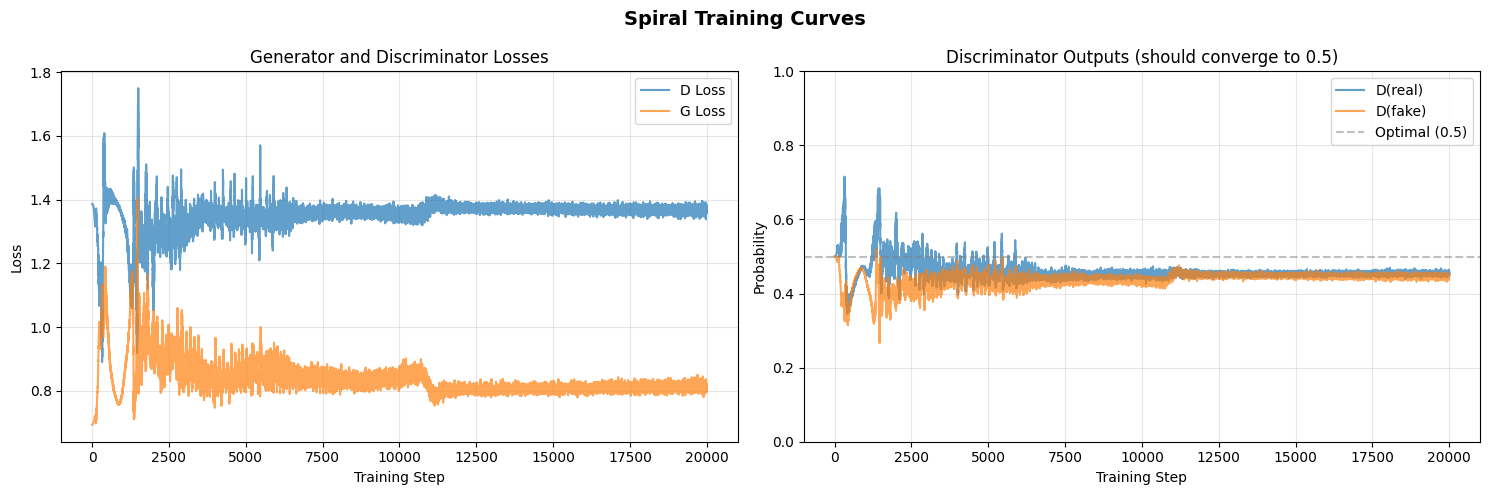

In [10]:
def plot_training_curves(history, title="Training Curves"):
    """
    Plot training losses and discriminator outputs.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    steps = history['steps']
    
    # Plot losses
    axes[0].plot(steps, history['d_loss'], label='D Loss', alpha=0.7, linewidth=1.5)
    axes[0].plot(steps, history['g_loss'], label='G Loss', alpha=0.7, linewidth=1.5)
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Generator and Discriminator Losses')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot discriminator outputs
    axes[1].plot(steps, history['d_real'], label='D(real)', alpha=0.7, linewidth=1.5)
    axes[1].plot(steps, history['d_fake'], label='D(fake)', alpha=0.7, linewidth=1.5)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Optimal (0.5)')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Discriminator Outputs (should converge to 0.5)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_training_curves(history_swiss, "Swiss Roll Training Curves")
plot_training_curves(history_spiral, "Spiral Training Curves")

---
## 6. Results & Analysis

Let's perform quantitative analysis of how well the GAN learned the distributions.

In [11]:
def qqplot(
    x: np.ndarray,
    y: np.ndarray,
    ax: Optional[plt.Axes] = None,
    title: str = "Q-Q Plot",
    xlabel: str = "Real Quantiles",
    ylabel: str = "Generated Quantiles",
) -> Tuple[plt.Axes, float, float]:
    """
    Create a quantile-quantile plot comparing two distributions.
    
    Returns:
        ax, ks_statistic, ks_pvalue
    """
    # Remove NaNs
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    # Calculate quantiles
    n_quantiles = min(len(x), len(y), 100)
    quantiles = np.linspace(0.01, 0.99, n_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)
    
    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(x_quantiles, y_quantiles, alpha=0.6, s=20, color='steelblue', edgecolors='navy')
    
    # Reference line (y=x)
    min_val = min(np.min(x_quantiles), np.min(y_quantiles))
    max_val = max(np.max(x_quantiles), np.max(y_quantiles))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
    
    # Statistics
    correlation = np.corrcoef(x_quantiles, y_quantiles)[0, 1]
    ks_stat, ks_pvalue = stats.ks_2samp(x, y)
    
    stats_text = f'Correlation: {correlation:.3f}\nKS stat: {ks_stat:.3f}\nKS p-value: {ks_pvalue:.3f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return ax, ks_stat, ks_pvalue

SWISS ROLL RESULTS


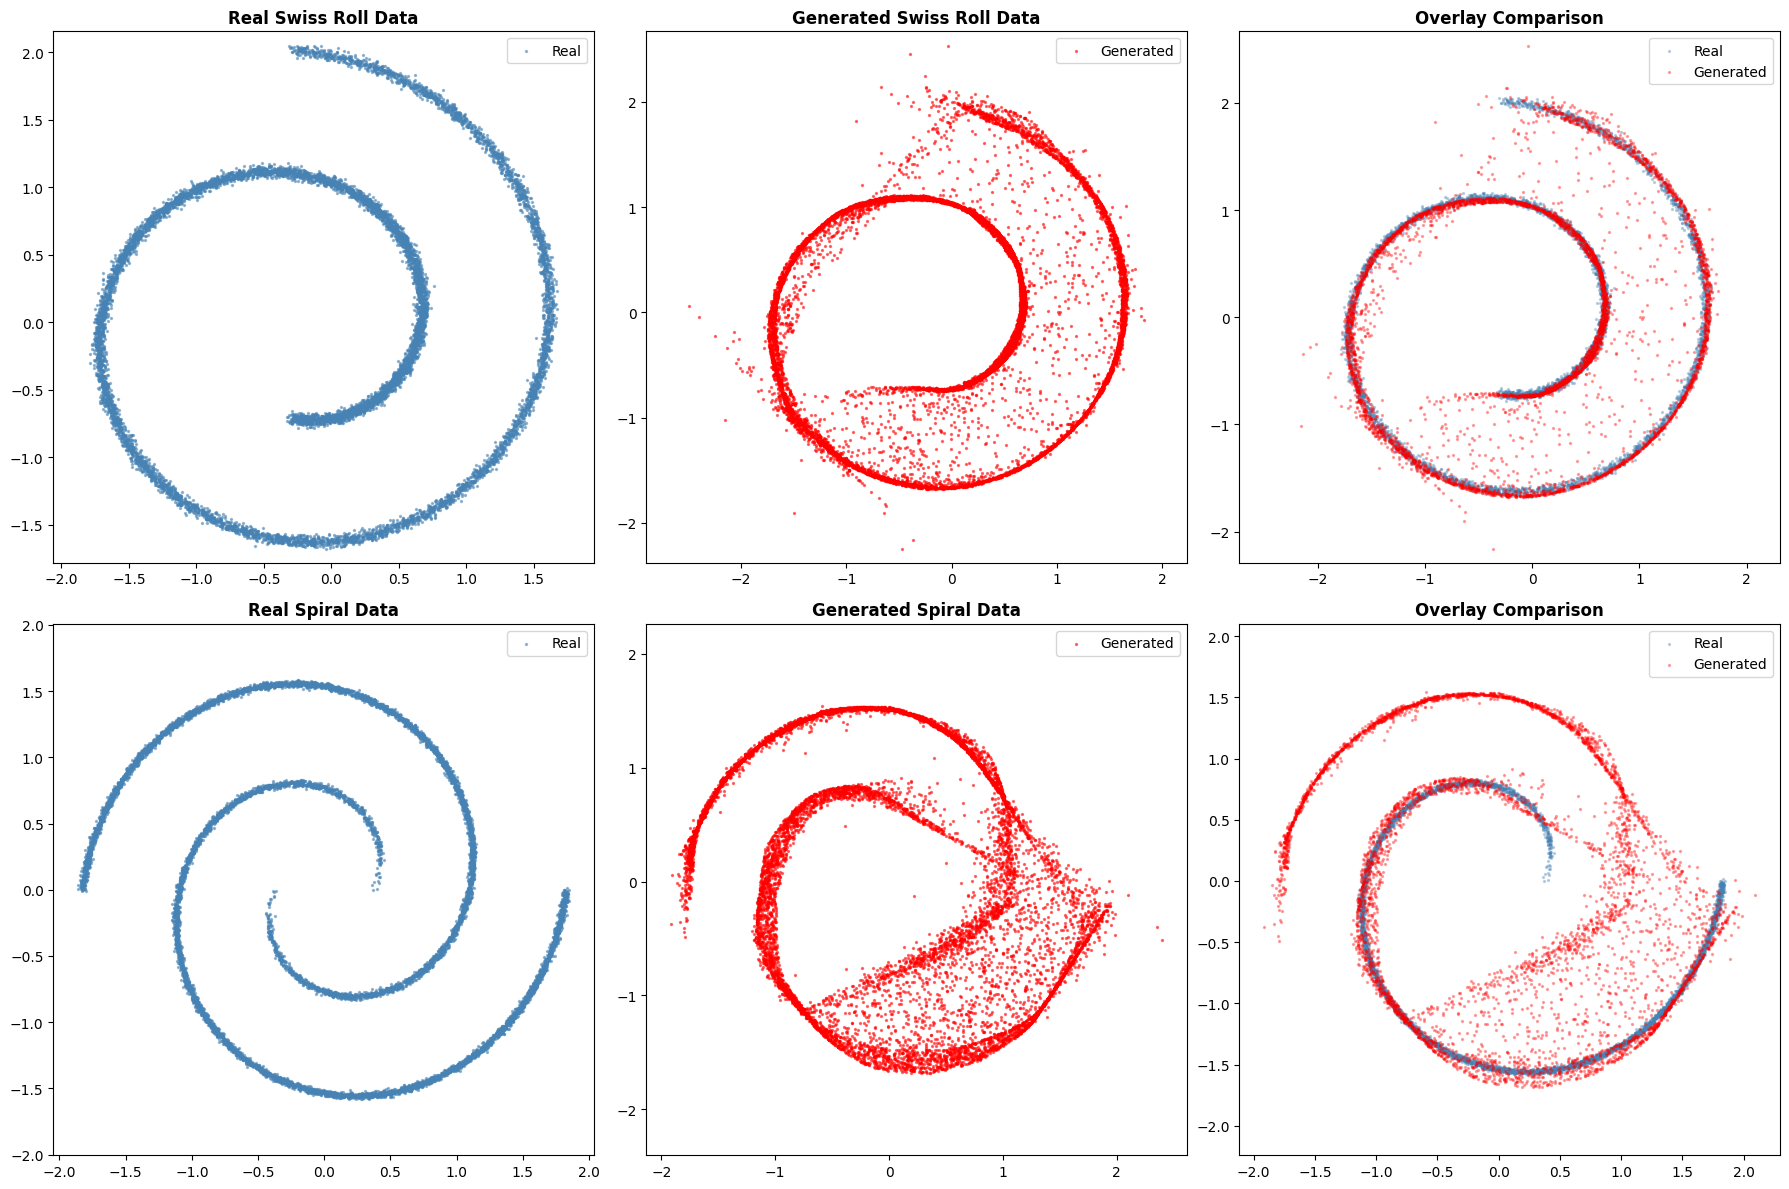

In [12]:
# Generate final samples
with torch.no_grad():
    z_swiss = torch.randn(10000, 2).to(device)
    final_swiss_samples = G_swiss(z_swiss).cpu().numpy()
    
    z_spiral = torch.randn(10000, 2).to(device)
    final_spiral_samples = G_spiral(z_spiral).cpu().numpy()

# Swiss Roll Analysis
print("=" * 60)
print("SWISS ROLL RESULTS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Swiss Roll
# Scatter comparison
axes[0, 0].scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], s=2, alpha=0.5, c='steelblue', label='Real')
axes[0, 0].set_title('Real Swiss Roll Data', fontweight='bold')
axes[0, 0].axis('equal')
axes[0, 0].legend()

axes[0, 1].scatter(final_swiss_samples[:, 0], final_swiss_samples[:, 1], s=2, alpha=0.5, c='red', label='Generated')
axes[0, 1].set_title('Generated Swiss Roll Data', fontweight='bold')
axes[0, 1].axis('equal')
axes[0, 1].legend()

# Overlay
axes[0, 2].scatter(swiss_roll_data[:5000, 0], swiss_roll_data[:5000, 1], s=2, alpha=0.3, c='steelblue', label='Real')
axes[0, 2].scatter(final_swiss_samples[:5000, 0], final_swiss_samples[:5000, 1], s=2, alpha=0.3, c='red', label='Generated')
axes[0, 2].set_title('Overlay Comparison', fontweight='bold')
axes[0, 2].axis('equal')
axes[0, 2].legend()

# Row 2: Spiral
axes[1, 0].scatter(spiral_data[:, 0], spiral_data[:, 1], s=2, alpha=0.5, c='steelblue', label='Real')
axes[1, 0].set_title('Real Spiral Data', fontweight='bold')
axes[1, 0].axis('equal')
axes[1, 0].legend()

axes[1, 1].scatter(final_spiral_samples[:, 0], final_spiral_samples[:, 1], s=2, alpha=0.5, c='red', label='Generated')
axes[1, 1].set_title('Generated Spiral Data', fontweight='bold')
axes[1, 1].axis('equal')
axes[1, 1].legend()

axes[1, 2].scatter(spiral_data[:5000, 0], spiral_data[:5000, 1], s=2, alpha=0.3, c='steelblue', label='Real')
axes[1, 2].scatter(final_spiral_samples[:5000, 0], final_spiral_samples[:5000, 1], s=2, alpha=0.3, c='red', label='Generated')
axes[1, 2].set_title('Overlay Comparison', fontweight='bold')
axes[1, 2].axis('equal')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

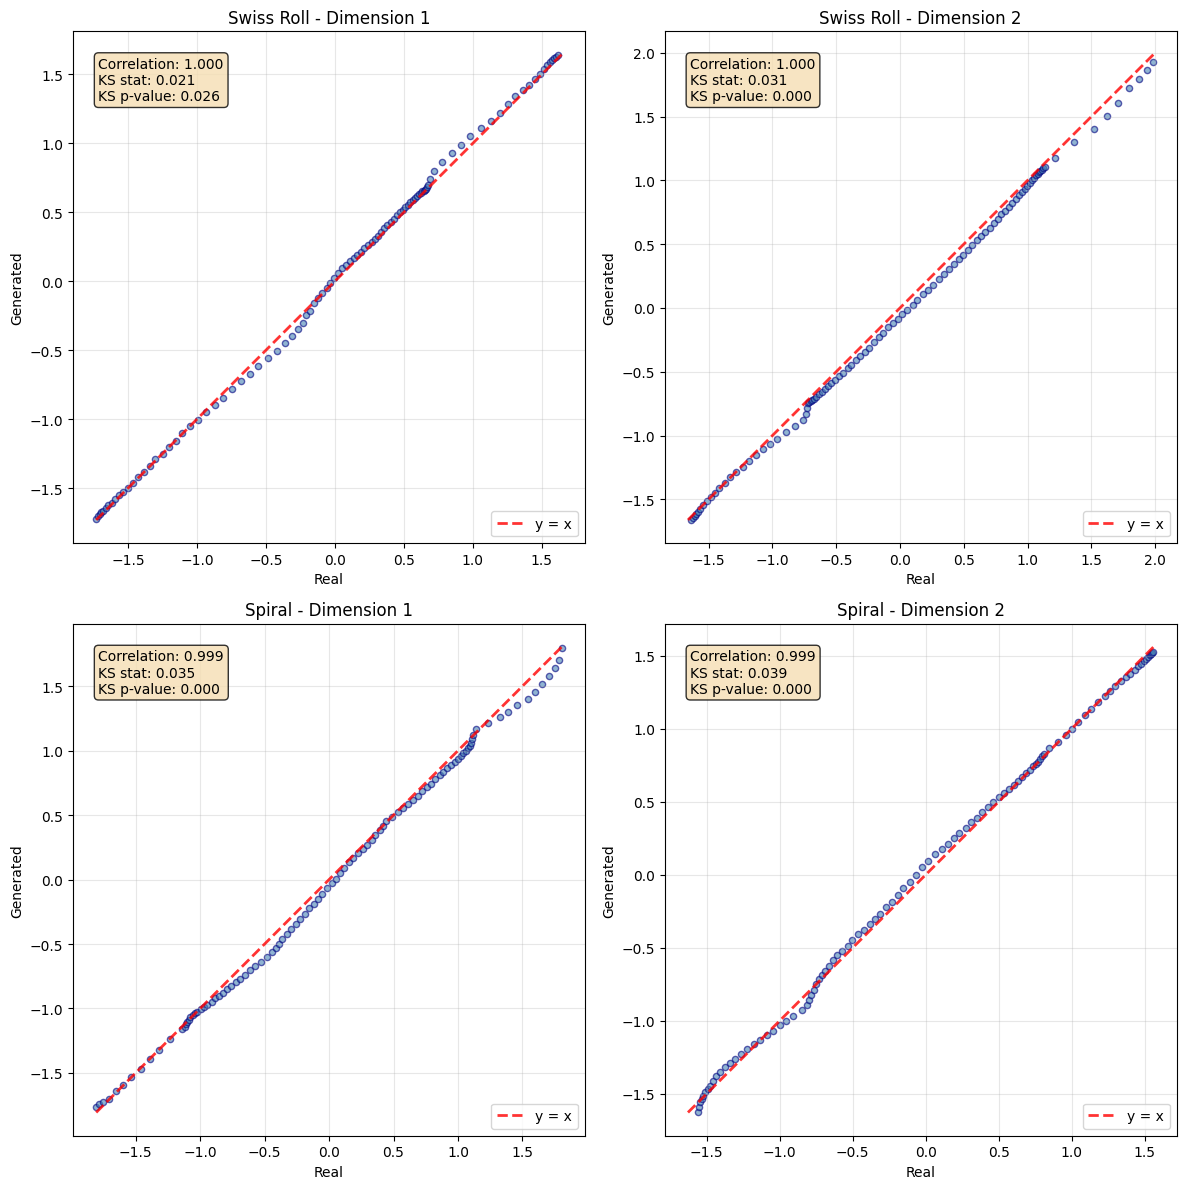

In [13]:
# Q-Q Plots for both dimensions
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Swiss Roll
qqplot(swiss_roll_data[:, 0], final_swiss_samples[:, 0], ax=axes[0, 0], 
       title='Swiss Roll - Dimension 1', xlabel='Real', ylabel='Generated')
qqplot(swiss_roll_data[:, 1], final_swiss_samples[:, 1], ax=axes[0, 1], 
       title='Swiss Roll - Dimension 2', xlabel='Real', ylabel='Generated')

# Spiral
qqplot(spiral_data[:, 0], final_spiral_samples[:, 0], ax=axes[1, 0], 
       title='Spiral - Dimension 1', xlabel='Real', ylabel='Generated')
qqplot(spiral_data[:, 1], final_spiral_samples[:, 1], ax=axes[1, 1], 
       title='Spiral - Dimension 2', xlabel='Real', ylabel='Generated')

plt.tight_layout()
plt.show()